# <center><h1>Project Shift, Don't Lift</center></h1> 

***
###### <center><h1>An investigation into position prediction in Formula 1</center></h1> 
***

<center><h1>Part III: ADDITIONAL MODELING</center></h1> 

## **INTRODUCTION**
This workbook focuses on additional modeling, specifically on the Lap time dataset in effort to engineer lap time features for each race, and then join this to the current model in hopes of increasing predictive power.

First steps will be to import the necessary tools by using the import function.

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=None
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Import Lap Time Data
laps_df = pd.read_csv('data/lap_times.csv')
laps_df.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [3]:
print(f'Shape: {laps_df.shape}')
print(f'# of Nulls: {laps_df.isna().sum().sum()}')
print(f'# of Duplicates: {laps_df.duplicated().sum()}')

Shape: (501586, 6)
# of Nulls: 0
# of Duplicates: 0


In [4]:
laps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501586 entries, 0 to 501585
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   raceId        501586 non-null  int64 
 1   driverId      501586 non-null  int64 
 2   lap           501586 non-null  int64 
 3   position      501586 non-null  int64 
 4   time          501586 non-null  object
 5   milliseconds  501586 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 23.0+ MB


- `raceId`: unique identifier for each race.
- `driverId`: unique identifier for each driver.
- `lap`: lap number, this could help provide predictive power for finishing position by engineering a feature to show change in position per lap.
- `position`: race position by the end of the lap, this could help provide predictive power for finishing position by engineering a feature to show change in position per lap.
- `time`: lap time, this could help provide predictive power for finishing position as well as opportunity for engineered features such as `lap_difference`.
- `milliseconds`: lap time in milliseconds, is considered duplicate information and would be dropped.

Next steps are to look at the selected columns to keep and confirm there is no ambiguity.

In [5]:
laps_df['raceId'].nunique()

463

- There are only 463 unique races observed in the lap time data set, however there is a total of 1,044 unique races out of the entire results data set that contains the target variable, finishing position. 

In [6]:
laps_df['driverId'].nunique()

135

- There is lap time data for only ~44% of all races as well as for only ~16% of all divers in the entire data set.

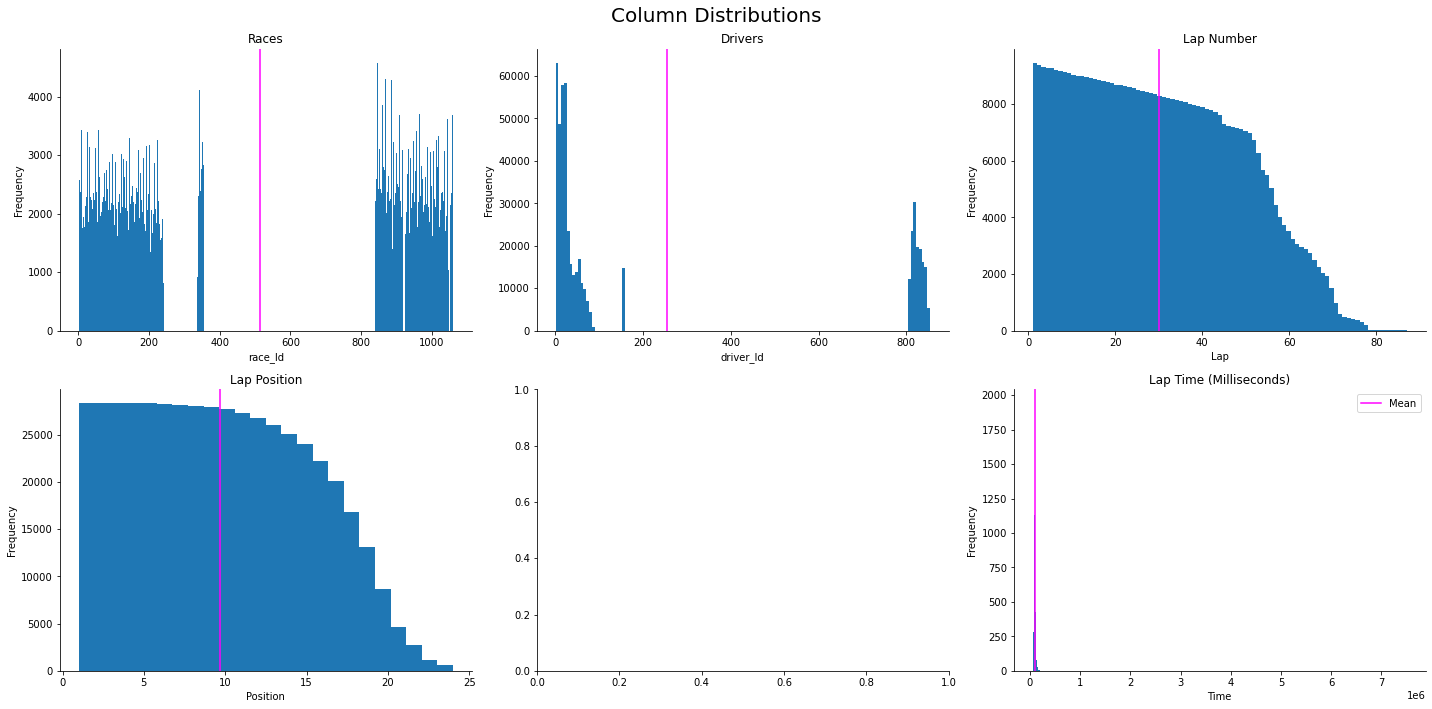

In [7]:
plt.subplots(2, 3, figsize=(20,10))  # create a 2x2 grid of subplots
plt.suptitle('Column Distributions', size=20)

# Historgram of grid
plt.subplot(2, 3, 1)
plt.hist(laps_df['raceId'], bins=laps_df['raceId'].nunique())
plt.title('Races')
plt.xlabel('race_Id')
plt.ylabel('Frequency')
plt.axvline(laps_df['raceId'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of finishing_position
plt.subplot(2,3,2)
plt.hist(laps_df['driverId'], bins=laps_df['driverId'].nunique())
plt.title('Drivers')
plt.xlabel('driver_Id')
plt.ylabel('Frequency')
plt.axvline(laps_df['driverId'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of completed_laps
plt.subplot(2,3,3)
plt.hist(laps_df['lap'], bins=laps_df['lap'].nunique())
plt.title('Lap Number')
plt.xlabel('Lap')
plt.ylabel('Frequency')
plt.axvline(laps_df['lap'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of race round
plt.subplot(2,3,4)
plt.hist(laps_df['position'], bins=laps_df['position'].nunique())
plt.title('Lap Position')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.axvline(laps_df['position'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

#Historgram of circuit_lng
plt.subplot(2,3,6)
plt.hist(laps_df['milliseconds'], bins=laps_df['milliseconds'].nunique())
plt.title('Lap Time (Milliseconds)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.axvline(laps_df['milliseconds'].mean(), label="Mean", c="magenta")
sns.despine() # Remove the top and right spines from plot

plt.legend()
plt.tight_layout()
plt.show()

## `avg_lap_time`

 - An **average lap time** feature was created in the **Lap Times** Tableau workbook and saved as an individual data set as seen below. This will be joined to the final data frame which will follow the same process as seen in Part 1.
- There were other engineered lap time features such as `Std_Deviation_of_laps` per race and `Fastest_Lap` that were considered and also seen in workbook, however not implemented due to: 
    - `Std_Deviation_of_laps`: null values are produced from drivers with 0 completed laps (crash or retire car on opening lap).
    - `Fastest_Lap`: assumed to produce high multicollinearity `avg_lap_time`.

In [8]:
lap_avgs = pd.read_csv('data/lap_avgs.csv')
lap_avgs.head()

,Driver Ref,Race Id,Avg. Milliseconds
0,perez,1046,"62,932.34"
1,ocon,1046,"63,053.24"
2,stroll,1046,"63,068.77"
3,latifi,1046,"63,070.12"
4,sainz,1046,"63,076.94"


## Results

In [9]:
results_df = pd.read_csv('data/results.csv')
results_df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [10]:
results_df = results_df.rename(columns = {'positionOrder':'finishing_position', 'laps':'completed_laps'})
results_df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,finishing_position,points,completed_laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [11]:
results_df = results_df.drop(['resultId', 'number', 'position', 'positionText', 'points', 'time', 'milliseconds', 'rank','fastestLap','fastestLapTime', 'fastestLapSpeed'], axis=1)
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,statusId
0,18,1,1,1,1,58,1
1,18,2,2,5,2,58,1
2,18,3,3,7,3,58,1
3,18,4,4,11,4,58,1
4,18,5,1,3,5,58,1


## Status

In [12]:
status_df = pd.read_csv('data/status.csv')
status_df.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [13]:
results_df = pd.merge(results_df, status_df, on = "statusId") 
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,statusId,status
0,18,1,1,1,1,58,1,Finished
1,18,2,2,5,2,58,1,Finished
2,18,3,3,7,3,58,1,Finished
3,18,4,4,11,4,58,1,Finished
4,18,5,1,3,5,58,1,Finished


- Looks good, now `statusId` will be dropped as this just duplicates information.

In [14]:
results_df = results_df.drop(['statusId'], axis=1)
results_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,status
0,18,1,1,1,1,58,Finished
1,18,2,2,5,2,58,Finished
2,18,3,3,7,3,58,Finished
3,18,4,4,11,4,58,Finished
4,18,5,1,3,5,58,Finished


## Races

In [15]:
races_df = pd.read_csv('data/races.csv')
races_df.head()

,raceId,year,round,circuitId,name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [16]:
races_df = races_df.rename(columns = {'name':'race_name'})
races_df.head()

,raceId,year,round,circuitId,race_name,date,time,url
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...


In [17]:
races_df = races_df.drop(['year', 'race_name', 'time', 'url'], axis=1)
races_df.head()

,raceId,round,circuitId,date
0,1,1,1,2009-03-29
1,2,2,2,2009-04-05
2,3,3,17,2009-04-19
3,4,4,3,2009-04-26
4,5,5,4,2009-05-10


## Drivers

In [18]:
drivers_df = pd.read_csv('data/drivers.csv')
drivers_df.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [19]:
drivers_df = drivers_df.drop(['forename', 'surname', 'number', 'code', 'url'], axis=1)
drivers_df.head()

,driverId,driverRef,dob,nationality
0,1,hamilton,1985-01-07,British
1,2,heidfeld,1977-05-10,German
2,3,rosberg,1985-06-27,German
3,4,alonso,1981-07-29,Spanish
4,5,kovalainen,1981-10-19,Finnish


## Circuits

In [20]:
circuits_df = pd.read_csv('data/circuits.csv')
circuits_df.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [21]:
circuits_df = circuits_df.rename(columns = {'lat':'circuit_lat', 'lng':'circuit_lng'})
circuits_df.head()

,circuitId,circuitRef,name,location,country,circuit_lat,circuit_lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [22]:
circuits_df = circuits_df.drop(['circuitRef', 'name', 'location', 'country', 'alt', 'url'], axis=1)
circuits_df.head()

,circuitId,circuit_lat,circuit_lng
0,1,-37.84970,144.96800
1,2,2.76083,101.73800
2,3,26.03250,50.51060
3,4,41.57000,2.26111
4,5,40.95170,29.40500


## Constructors

In [23]:
constructors_df = pd.read_csv('data/constructors.csv')
constructors_df.head()

,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [24]:
constructors_df = constructors_df.rename(columns = {'name':'constructor', 'nationality':'constructor_nationality'})
constructors_df.head()

,constructorId,constructorRef,constructor,constructor_nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [25]:
constructors_df['constructor_nationality'] = 'C.' + constructors_df['constructor_nationality'].astype(str)

In [26]:
constructors_df = constructors_df.drop(['constructorRef', 'url'], axis=1)
constructors_df.head()

,constructorId,constructor,constructor_nationality
0,1,McLaren,C.British
1,2,BMW Sauber,C.German
2,3,Williams,C.British
3,4,Renault,C.French
4,5,Toro Rosso,C.Italian


## Final DataFrame
Now that all individual data sets have been reviewed, a final dataframe can be created by joining the selected data sets per their unique identifier as seen below.

In [27]:
#join results with drivers by column driverID, using inner join
driver_results = pd.merge(results_df, drivers_df, on='driverId')
#join races with driver_results by column raceID, using inner join
race_results = pd.merge(driver_results, races_df, on='raceId')
#join circuits with race_results by column circuitID, using inner join
circuit_results = pd.merge(race_results, circuits_df, on='circuitId')
#join constructorDF with dfresulcons by column constructorID, using inner join
f1_df = pd.merge(circuit_results, constructors_df, on='constructorId')

f1_df.head()

,raceId,driverId,constructorId,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,circuitId,date,circuit_lat,circuit_lng,constructor,constructor_nationality
0,18,1,1,1,1,58,Finished,hamilton,1985-01-07,British,1,1,2008-03-16,-37.8497,144.968,McLaren,C.British
1,18,5,1,3,5,58,Finished,kovalainen,1981-10-19,Finnish,1,1,2008-03-16,-37.8497,144.968,McLaren,C.British
2,36,1,1,4,3,58,Finished,hamilton,1985-01-07,British,1,1,2007-03-18,-37.8497,144.968,McLaren,C.British
3,36,4,1,2,2,58,Finished,alonso,1981-07-29,Spanish,1,1,2007-03-18,-37.8497,144.968,McLaren,C.British
4,338,1,1,11,6,58,Finished,hamilton,1985-01-07,British,2,1,2010-03-28,-37.8497,144.968,McLaren,C.British


In [28]:
print(f'Shape: {f1_df.shape}')
print(f'# of Nulls: {f1_df.isna().sum().sum()}')
print(f'# of Duplicates: {f1_df.duplicated().sum()}')

Shape: (25140, 17)
# of Nulls: 0
# of Duplicates: 0


Now that a final df is created, time to remove duplicate information within the features.

In [29]:
f1_df = f1_df.drop(['driverId', 'constructorId', 'circuitId'], axis=1)
f1_df.head()

,raceId,grid,finishing_position,completed_laps,status,driverRef,dob,nationality,round,date,circuit_lat,circuit_lng,constructor,constructor_nationality
0,18,1,1,58,Finished,hamilton,1985-01-07,British,1,2008-03-16,-37.8497,144.968,McLaren,C.British
1,18,3,5,58,Finished,kovalainen,1981-10-19,Finnish,1,2008-03-16,-37.8497,144.968,McLaren,C.British
2,36,4,3,58,Finished,hamilton,1985-01-07,British,1,2007-03-18,-37.8497,144.968,McLaren,C.British
3,36,2,2,58,Finished,alonso,1981-07-29,Spanish,1,2007-03-18,-37.8497,144.968,McLaren,C.British
4,338,11,6,58,Finished,hamilton,1985-01-07,British,2,2010-03-28,-37.8497,144.968,McLaren,C.British


In [30]:
print(f'Shape: {f1_df.shape}')
print(f'Duplication: {f1_df.duplicated().sum()}')
print(f'Null Values: {f1_df.isna().sum().sum()}')

Shape: (25140, 14)
Duplication: 0
Null Values: 0


- This looks good, will save this final data frame to a csv for modeling.

In [31]:
#f1_df.to_csv("data/f1_dfa.csv", index=False)

- The final data frame is then joined with the average lap time data set in Tableau and seen below.

In [32]:
f1_df2 = pd.read_csv('data/f1_df2.csv')
f1_df2.head()

,constructor,constructor_nationality,date,dob,Driver Ref1,driverRef,nationality,Race Id1,raceId,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round
0,McLaren,C.British,3/16/2008,1/7/1985,hamilton,hamilton,British,18,18,Finished,98114.07,-37.8497,144.968,58,1,1,1
1,McLaren,C.British,3/16/2008,10/19/1981,kovalainen,kovalainen,Finnish,18,18,Finished,98424.66,-37.8497,144.968,58,5,3,1
2,McLaren,C.British,3/18/2007,1/7/1985,hamilton,hamilton,British,36,36,Finished,88747.67,-37.8497,144.968,58,3,4,1
3,McLaren,C.British,3/18/2007,7/29/1981,alonso,alonso,Spanish,36,36,Finished,88551.93,-37.8497,144.968,58,2,2,1
4,McLaren,C.British,3/28/2010,1/7/1985,hamilton,hamilton,British,338,338,Finished,97352.22,-37.8497,144.968,58,6,11,2


In [33]:
print(f'Shape: {f1_df2.shape}')
print(f'Duplication: {f1_df2.duplicated().sum()}')
print(f'Null Values: {f1_df2.isna().sum().sum()}')

Shape: (9466, 17)
Duplication: 0
Null Values: 0


Now that a final df is created, time to remove duplicate information within the features.

In [34]:
f1_df2 = f1_df2.drop(['Driver Ref1', 'raceId', 'Race Id1'], axis=1)
f1_df2.head()

,constructor,constructor_nationality,date,dob,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round
0,McLaren,C.British,3/16/2008,1/7/1985,hamilton,British,Finished,98114.07,-37.8497,144.968,58,1,1,1
1,McLaren,C.British,3/16/2008,10/19/1981,kovalainen,Finnish,Finished,98424.66,-37.8497,144.968,58,5,3,1
2,McLaren,C.British,3/18/2007,1/7/1985,hamilton,British,Finished,88747.67,-37.8497,144.968,58,3,4,1
3,McLaren,C.British,3/18/2007,7/29/1981,alonso,Spanish,Finished,88551.93,-37.8497,144.968,58,2,2,1
4,McLaren,C.British,3/28/2010,1/7/1985,hamilton,British,Finished,97352.22,-37.8497,144.968,58,6,11,2


In [35]:
print(f'Shape: {f1_df2.shape}')
print(f'Duplication: {f1_df2.duplicated().sum()}')
print(f'Null Values: {f1_df2.isna().sum().sum()}')

Shape: (9466, 14)
Duplication: 0
Null Values: 0


## Feature Engineering
### `grid`
Drivers starting with grid position of '0' are actually starting at the end of the grid. This is going to effect predicting power & correlation as of 6% of the values are seen and are numerically misrepresented in order of grid position. One solution is to find the average grid count for these races in which contained a "0" grid position, and substitute the numbers. This analysis was executed in the **Results - Grid** tableau workbook, where it appears the average grid count is 27.64, therefore will encode all '0' grid positions as '27.64'.
- Note this isn't a perfect solution, however is should provide greater modeling accuracy results compared to not changing at all.

In [36]:
a = f1_df2['grid']
f1_df2['grid'] = np.where((f1_df2['grid'] == 0), 27.64, a)
f1_df2['grid'].value_counts()

1.00     454
2.00     453
6.00     452
5.00     452
3.00     450
8.00     450
4.00     450
7.00     448
10.00    448
17.00    447
13.00    444
9.00     443
15.00    442
18.00    439
11.00    438
16.00    437
12.00    436
19.00    435
14.00    434
20.00    409
21.00    235
22.00    235
23.00     56
24.00     52
27.64     27
Name: grid, dtype: int64

### `date`
Time to extract the day, month, and year information in `date` column to separate columns. Will need to change dtype first.

In [37]:
# cast 'date' column objects as dates
f1_df2['date'] = f1_df2['date'].astype('datetime64')

# extract day, month, & year to new columns
f1_df2['race_day'] = f1_df2['date'].dt.day
f1_df2['race_month'] = f1_df2['date'].dt.month
f1_df2['race_year'] = f1_df2['date'].dt.year

# drop duplicated date column
f1_df2 = f1_df2.drop(['date'], axis=1)

# check results
f1_df2.head()

,constructor,constructor_nationality,dob,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round,race_day,race_month,race_year
0,McLaren,C.British,1/7/1985,hamilton,British,Finished,98114.07,-37.8497,144.968,58,1,1.0,1,16,3,2008
1,McLaren,C.British,10/19/1981,kovalainen,Finnish,Finished,98424.66,-37.8497,144.968,58,5,3.0,1,16,3,2008
2,McLaren,C.British,1/7/1985,hamilton,British,Finished,88747.67,-37.8497,144.968,58,3,4.0,1,18,3,2007
3,McLaren,C.British,7/29/1981,alonso,Spanish,Finished,88551.93,-37.8497,144.968,58,2,2.0,1,18,3,2007
4,McLaren,C.British,1/7/1985,hamilton,British,Finished,97352.22,-37.8497,144.968,58,6,11.0,2,28,3,2010


### `dob`
Time to extract the day, month, and year information in driver's `dob` column to separate columns. Will need to change dtype first.

In [38]:
# cast 'dob' column objects as dates
f1_df2['dob'] = f1_df2['dob'].astype('datetime64')

# extract day, month, & year to new columns
f1_df2['dob_day'] = f1_df2['dob'].dt.day
f1_df2['dob_month'] = f1_df2['dob'].dt.month
f1_df2['dob_year'] = f1_df2['dob'].dt.year

# drop duplicated date column
f1_df2 = f1_df2.drop(['dob'], axis=1)

# check results
f1_df2.head()

,constructor,constructor_nationality,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round,race_day,race_month,race_year,dob_day,dob_month,dob_year
0,McLaren,C.British,hamilton,British,Finished,98114.07,-37.8497,144.968,58,1,1.0,1,16,3,2008,7,1,1985
1,McLaren,C.British,kovalainen,Finnish,Finished,98424.66,-37.8497,144.968,58,5,3.0,1,16,3,2008,19,10,1981
2,McLaren,C.British,hamilton,British,Finished,88747.67,-37.8497,144.968,58,3,4.0,1,18,3,2007,7,1,1985
3,McLaren,C.British,alonso,Spanish,Finished,88551.93,-37.8497,144.968,58,2,2.0,1,18,3,2007,29,7,1981
4,McLaren,C.British,hamilton,British,Finished,97352.22,-37.8497,144.968,58,6,11.0,2,28,3,2010,7,1,1985


### `finishing_position`
The **Target Variable**; will encode the top 5 finishing positions as "1", the rest as "0".

In [39]:
a = f1_df2['finishing_position']
rank1 =  np.where(a <= 5, 1, 0) # take top 5, encode as '1', all remaining positions encoded as '0'.
f1_df2['encoded_finish'] = rank1
f1_df2.head(25)

,constructor,constructor_nationality,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish
0,McLaren,C.British,hamilton,British,Finished,98114.07,-37.8497,144.968,58,1,1.0,1,16,3,2008,7,1,1985,1
1,McLaren,C.British,kovalainen,Finnish,Finished,98424.66,-37.8497,144.968,58,5,3.0,1,16,3,2008,19,10,1981,1
2,McLaren,C.British,hamilton,British,Finished,88747.67,-37.8497,144.968,58,3,4.0,1,18,3,2007,7,1,1985,1
3,McLaren,C.British,alonso,Spanish,Finished,88551.93,-37.8497,144.968,58,2,2.0,1,18,3,2007,29,7,1981,1
4,McLaren,C.British,hamilton,British,Finished,97352.22,-37.8497,144.968,58,6,11.0,2,28,3,2010,7,1,1985,0
5,McLaren,C.British,button,British,Finished,96836.74,-37.8497,144.968,58,1,4.0,2,28,3,2010,19,1,1980,1
6,McLaren,C.British,hamilton,British,Finished,92975.10,-37.8497,144.968,58,2,2.0,1,27,3,2011,7,1,1985,1
7,McLaren,C.British,button,British,Finished,93526.95,-37.8497,144.968,58,6,4.0,1,27,3,2011,19,1,1980,0
8,McLaren,C.British,hamilton,British,Finished,97476.55,-37.8497,144.968,58,3,1.0,1,18,3,2012,7,1,1985,1
9,McLaren,C.British,button,British,Finished,97406.29,-37.8497,144.968,58,1,2.0,1,18,3,2012,19,1,1980,1


In [40]:
f1_df2['encoded_finish'].dtype

dtype('int32')

- Not sure why it converted to 'int32', however to keep things consistent will convert to 'int62'.

In [41]:
f1_df2['encoded_finish'] = f1_df2['encoded_finish'].astype('int64')
f1_df2['encoded_finish'].dtype

dtype('int64')

### `status`
As previously mentioned, converting the `status` column into a binary column is essential in correctly identifying if a driver simply finished the race or not. Statuses that are coded as 'finished' or '+ n_laps' will be encoded as 1 ('finished') and all other statuses will be encoded as 0 ('not finished') by utilizing the **.where()** function.
- **+ n_laps** means the the driver finished the race, however they were n laps behind the racer winner's finishing lap when they cross the checker flag.

In [42]:
f1_df2['status'].sort_values(ascending=True).unique()

array(['+1 Lap', '+10 Laps', '+11 Laps', '+12 Laps', '+14 Laps',
       '+17 Laps', '+2 Laps', '+26 Laps', '+3 Laps', '+4 Laps',
       '+42 Laps', '+5 Laps', '+6 Laps', '+7 Laps', '+8 Laps', '+9 Laps',
       'Accident', 'Alternator', 'Battery', 'Brake duct', 'Brakes',
       'Broken wing', 'Chassis', 'Clutch', 'Collision',
       'Collision damage', 'Crankshaft', 'Damage', 'Debris',
       'Differential', 'Disqualified', 'Driver Seat', 'Driveshaft',
       'Drivetrain', 'ERS', 'Electrical', 'Electronics', 'Engine',
       'Engine fire', 'Engine misfire', 'Excluded', 'Exhaust', 'Finished',
       'Fire', 'Front wing', 'Fuel', 'Fuel pressure', 'Fuel pump',
       'Fuel rig', 'Fuel system', 'Gearbox', 'Halfshaft', 'Handling',
       'Heat shield fire', 'Hydraulics', 'Illness', 'Injury',
       'Mechanical', 'Not classified', 'Oil leak', 'Oil line',
       'Oil pressure', 'Oil pump', 'Out of fuel', 'Overheating',
       'Physical', 'Pneumatics', 'Power Unit', 'Power loss', 'Puncture',
  

In [43]:
f1_df2['status'] = np.where(
    (f1_df2['status'] == 'Finished')| 
    (f1_df2['status'] == '+1 Lap')|
    (f1_df2['status'] == '+2 Laps')|
    (f1_df2['status'] == '+3 Laps')|
    (f1_df2['status'] == '+4 Laps')|
    (f1_df2['status'] == '+5 Laps')|
    (f1_df2['status'] == '+6 Laps')|
    (f1_df2['status'] == '+7 Laps')|
    (f1_df2['status'] == '+8 Laps')|
    (f1_df2['status'] == '+9 Laps')|
    (f1_df2['status'] == '+10 Laps')|
    (f1_df2['status'] == '+11 Laps')|
    (f1_df2['status'] == '+12 Laps')|
    (f1_df2['status'] == '+13 Laps')|
    (f1_df2['status'] == '+14 Laps')|
    (f1_df2['status'] == '+15 Laps')|
    (f1_df2['status'] == '+16 Laps')|
    (f1_df2['status'] == '+17 Laps')|
    (f1_df2['status'] == '+18 Laps')|
    (f1_df2['status'] == '+19 Laps')|
    (f1_df2['status'] == '+20 Laps')|
    (f1_df2['status'] == '+21 Laps')|
    (f1_df2['status'] == '+22 Laps')|
    (f1_df2['status'] == '+23 Laps')|
    (f1_df2['status'] == '+24 Laps')|
    (f1_df2['status'] == '+25 Laps')|
    (f1_df2['status'] == '+26 Laps')|
    (f1_df2['status'] == '+29 Laps')|
    (f1_df2['status'] == '+30 Laps')|
    (f1_df2['status'] == '+42 Laps')|
    (f1_df2['status'] == '+44 Laps')|
    (f1_df2['status'] == '+46 Laps'), 1, 0)

f1_df2['status'].value_counts()

1    7108
0    2358
Name: status, dtype: int64

In [44]:
f1_df2.head()

,constructor,constructor_nationality,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish
0,McLaren,C.British,hamilton,British,1,98114.07,-37.8497,144.968,58,1,1.0,1,16,3,2008,7,1,1985,1
1,McLaren,C.British,kovalainen,Finnish,1,98424.66,-37.8497,144.968,58,5,3.0,1,16,3,2008,19,10,1981,1
2,McLaren,C.British,hamilton,British,1,88747.67,-37.8497,144.968,58,3,4.0,1,18,3,2007,7,1,1985,1
3,McLaren,C.British,alonso,Spanish,1,88551.93,-37.8497,144.968,58,2,2.0,1,18,3,2007,29,7,1981,1
4,McLaren,C.British,hamilton,British,1,97352.22,-37.8497,144.968,58,6,11.0,2,28,3,2010,7,1,1985,0


### New Feature - `age_at_race`
This is the new feature analyzed from part I that will be now added into the dataframe.

In [45]:
f1_df2['age_at_race'] = f1_df2['race_year'] - f1_df2['dob_year']
f1_df2.head()

,constructor,constructor_nationality,driverRef,nationality,status,avg_lap_time,circuit_lat,circuit_lng,completed_laps,finishing_position,grid,round,race_day,race_month,race_year,dob_day,dob_month,dob_year,encoded_finish,age_at_race
0,McLaren,C.British,hamilton,British,1,98114.07,-37.8497,144.968,58,1,1.0,1,16,3,2008,7,1,1985,1,23
1,McLaren,C.British,kovalainen,Finnish,1,98424.66,-37.8497,144.968,58,5,3.0,1,16,3,2008,19,10,1981,1,27
2,McLaren,C.British,hamilton,British,1,88747.67,-37.8497,144.968,58,3,4.0,1,18,3,2007,7,1,1985,1,22
3,McLaren,C.British,alonso,Spanish,1,88551.93,-37.8497,144.968,58,2,2.0,1,18,3,2007,29,7,1981,1,26
4,McLaren,C.British,hamilton,British,1,97352.22,-37.8497,144.968,58,6,11.0,2,28,3,2010,7,1,1985,0,25


- This is looking great, however as mentioned before **onehotencoding** is carried out for the remaining categorical features (will make data frame contain several columns), will visit column correlations to see which columns are statically significant.

### Exploring correlations
- A key part of the regression modeling process is to explore correlations (not only between the dependent(target) and independent(predictor) variables, but also between each independent(predictor) variables). 
- A correlation gives us an understanding of how variables vary with respect to another. Investigating the correlations helps determine which features are likely to have the greatest impact on the dependent variable.
- Will utilize the Backward Variable Selection process that starts with all the variables, and then removes the least useful variables, one-at-a-time. 

In [46]:
from scipy.stats import pearsonr

def pearson_df(dataframe, target, alpha=0.05):
    '''
    This function takes a dataframe with a column of interest (target), a significance threshold (alpha) as inputs. It then calculates the correlation coefficients
    and p-values using scipy.stats.pearsonr(), and returns a dataframe of the results
    
    Parameters:
    -----------
    dataframe: a pandas dataframe containing the data to compare
    target: a string specifying one of the columns in the dataframe to compare to the rest of the data
    alpha: a significance threshold for evaluating p-values (default 0.05)
    
    Returns:
    --------
    output: a dataframe containing correlation coefficients and p-values for each variable in dataframe w.r.t. the target variable
    
    '''
    
    # Validate the inputs
    assert isinstance(dataframe, pd.DataFrame), 'dataframe must be a pandas DataFrame'
    assert isinstance(target, str), 'target must be a string'
    assert isinstance(alpha, float), 'alpha must be a float'
    assert(0 <= alpha <= 1), 'alpha must be between 0 and 1'
    
    # Instantiating empty lists
    variable_names = []
    corr_list = []
    p_value_list = []
    
    # Looping across all of the columns in the dataframe
    for column in range(dataframe.shape[1]):
        
        # Calculating the coefficient and p-value for each column w.r.t. the target variable
        corr, p_value = pearsonr(dataframe.iloc[:, column], dataframe[target])
        
        # Add the column name, coefficient, and p-value to their respective lists
        variable_names.append(dataframe.columns[column])
        corr_list.append(corr)
        p_value_list.append(p_value)

    # Turn the three lists into a dataframe for easier viewing
    output = pd.DataFrame(index=variable_names, data={'coefficient': corr_list, 'p-value': p_value_list})
    
    # Add a column which states whether the correlation is significant
    output[f'p-value <= {alpha}'] = np.where(output['p-value'] <= alpha, True, False)
    
    # Drop the target variable from the dataframe
    output = output.drop(target)
    
    print(f'Correlations between data columns and {target}:')
    
    return output

In [47]:
f1_df2.drop(columns=['finishing_position'], inplace=True) # drop the 'finishing_position' now that it's been encoded to 'encoded_finish'
nf1_df = f1_df2.select_dtypes(["int64", "float64"]) # get all numeric columns
correlation_df = pearson_df(nf1_df, 'encoded_finish') # run function for column correlations against encoded_finish. 
correlation_df

Correlations between data columns and encoded_finish:


,coefficient,p-value,p-value <= 0.05
avg_lap_time,-0.073308,9.263200e-13,True
circuit_lat,-0.001689,8.694654e-01,False
circuit_lng,-0.003055,7.663158e-01,False
completed_laps,0.267524,7.526235e-155,True
grid,-0.559229,0.000000e+00,True
round,-0.001613,8.752927e-01,False
race_day,-0.004776,6.421848e-01,False
race_month,-0.001016,9.212705e-01,False
race_year,0.000906,9.297545e-01,False
dob_day,0.002565,8.029688e-01,False


- The correlation coefficients between `circuit_lat`, `circuit_lng`, `round`, `race_day`, `race_month`, `race_year`, `dob_day`, `dob_month` and the target variable `encoded_position` are not statistically significant (p-value > 0.05), therefore should be dropped.
- Through trial an error however, it's discovered that dropping `dob_day` creates that data to have duplicates given so much unique information is stripped away. Given its low p-value, will decide to keep for modeling for the sake of not creating to many duplicate rows.
- Before doing so however, the strength of these correlations can be visualized below:

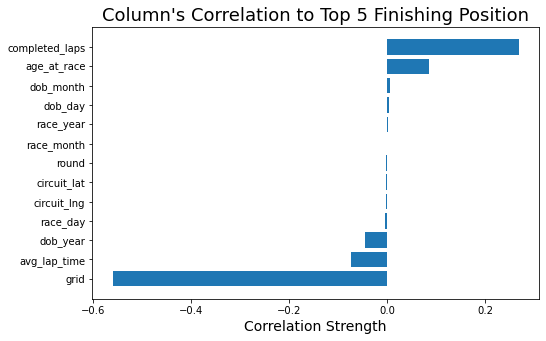

In [48]:
plt.figure(figsize=(8,5))
correlation_df.sort_values(by='coefficient', inplace=True)
plt.barh(correlation_df.index, correlation_df['coefficient'])
plt.title("Column's Correlation to Top 5 Finishing Position", fontsize=18)
plt.xlabel("Correlation Strength", fontsize=14)
plt.show()

Correlation falls on a range of [-1,1],

-1 indicates a perfect negative correlation relationship.
0 indicates no correlation relationship.
and 1 indicates a perfect positive correlation relationship.

**Observations:**

- `completed_lap`: highest positive correlation, makes sense as more laps completed the greater probability finishing in the Top 5 position, or in this case value of 1.
- `age_at_race`: positive correlation, interesting! The older the driver is at the race, the greater probability finishing in the Top 5 position, or in this case value of 1. This makes sense though given the difficulty to podium in F1 - drivers on the top teams usually already have a few years of experience in F1.
 - `dob_year`: negative correlation, which follows the `age_at_race` meaning the older the driver is, the greater probability finishing in the Top 5 position, or in this case value of 1.
- `avg_lap_time`: largest negative correlation, this makes sense as the lower a driver's avg lap is (quicker), the greater probability finishing in the Top 5 position, or in this case value of 1.
- `grid`: largest negative correlation, this makes sense as the lower the grid position a driver starts the race, the greater probability finishing in the Top 5 position, or in this case value of 1.

Time to check correlation between the the independent variables to ensure no multicollinearity. 

In [49]:
# Separate the data into X and y variables
X = nf1_df.drop(columns=['encoded_finish', 'circuit_lat', 'circuit_lng', 'round', 'race_day', 'race_month', 'race_year', 'dob_day', 'dob_month'], inplace=False) # X is the data containing the independent variables.
y = nf1_df['encoded_finish'] # y is the target. The dependent variable.

In [50]:
df_corr = X.corr()
df_corr

,avg_lap_time,completed_laps,grid,dob_year,age_at_race
avg_lap_time,1.000000,-0.353963,0.082860,0.105158,-0.014490
completed_laps,-0.353963,1.000000,-0.132974,0.101273,0.011764
grid,0.082860,-0.132974,1.000000,0.060122,-0.126663
dob_year,0.105158,0.101273,0.060122,1.000000,-0.606296
age_at_race,-0.014490,0.011764,-0.126663,-0.606296,1.000000


- Again, large correlation matrix tables are difficult to absorb, therefore the correlation is better visualized using a heatmap as seen below

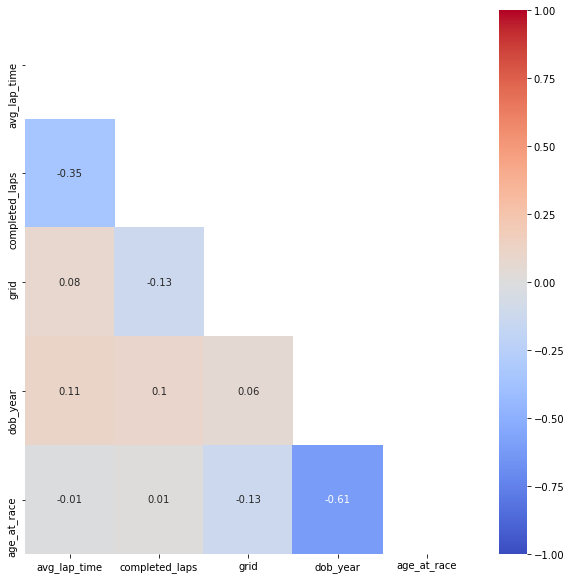

In [51]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_corr.round(2), annot=True, vmin=-1, vmax=1, cmap="coolwarm", mask=np.triu(df_corr))
plt.show()

- In the current predictors, there are no strong correlations however there still is a chance for multicollinearity when using a combination of two or more columns to describe another predictor. 
- To check for multicollinearity, the variance inflation factor can be utilized as it it quantifies the severity of multicollinearity in an ordinary least squares regression analysis as seen below. VIF above 10 is typically considered high, however a cutoff of 5 is also commonly used.

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

avg_lap_time      25.365466
completed_laps    11.564475
grid               4.305396
dob_year          86.606253
age_at_race       34.879888
dtype: float64

- As seen in the above VIF table, the majority columns have a low magnitude of multicollinearity, but `race_year` and `age_at_race` have high magnitudes of multicollinearity. Will drop `race_year` given it's lower correlation strength.

In [53]:
X.drop(columns=['dob_year'], inplace=True)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

avg_lap_time      14.991513
completed_laps     8.036746
grid               3.945015
age_at_race       20.417893
dtype: float64

- This is looking good. `age_at_race` is still slightly high but needed to maintain amount of duplicates. Will drop all specified columns on the **nf1_df** dataframe for easier final concatenation.

In [54]:
nf1_df.drop(columns=['circuit_lat', 'circuit_lng', 'round', 'race_day', 'race_month', 'race_year', 'dob_day', 'dob_month', 'dob_year'], inplace=True)
nf1_df.head()

,avg_lap_time,completed_laps,grid,encoded_finish,age_at_race
0,98114.07,58,1.0,1,23
1,98424.66,58,3.0,1,27
2,88747.67,58,4.0,1,22
3,88551.93,58,2.0,1,26
4,97352.22,58,11.0,0,25


- Look good, now onto OHE!

### `nationality`

In [55]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
d_nationality = pd.DataFrame(f1_df2['nationality'])
encoded = ohe.fit_transform(d_nationality)
encoded

<9466x33 sparse matrix of type '<class 'numpy.float64'>'
	with 9466 stored elements in Compressed Sparse Row format>

In [56]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

In [57]:
ohe.categories_

[array(['American', 'Argentine', 'Australian', 'Austrian', 'Belgian',
        'Brazilian', 'British', 'Canadian', 'Colombian', 'Czech', 'Danish',
        'Dutch', 'Finnish', 'French', 'German', 'Hungarian', 'Indian',
        'Indonesian', 'Irish', 'Italian', 'Japanese', 'Malaysian',
        'Mexican', 'Monegasque', 'New Zealander', 'Polish', 'Portuguese',
        'Russian', 'Spanish', 'Swedish', 'Swiss', 'Thai', 'Venezuelan'],
       dtype=object)]

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [58]:
# Put into a dataframe to get column names
driver_nat_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
driver_nat_df.head()

,American,Argentine,Australian,Austrian,Belgian,Brazilian,British,Canadian,Colombian,Czech,Danish,Dutch,Finnish,French,German,Hungarian,Indian,Indonesian,Irish,Italian,Japanese,Malaysian,Mexican,Monegasque,New Zealander,Polish,Portuguese,Russian,Spanish,Swedish,Swiss,Thai,Venezuelan
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
driver_nat_df.shape

(9466, 33)

### `driverRef`

In [60]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
d_ref = pd.DataFrame(f1_df2['driverRef'])
encoded = ohe.fit_transform(d_ref)
encoded

<9466x135 sparse matrix of type '<class 'numpy.float64'>'
	with 9466 stored elements in Compressed Sparse Row format>

In [61]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [62]:
# Put into a dataframe to get column names
driver_ref_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
driver_ref_df.head()

,aitken,albers,albon,alesi,alguersuari,alonso,ambrosio,badoer,barrichello,baumgartner,berger,bernoldi,bottas,bourdais,brendon_hartley,brundle,bruni,bruno_senna,buemi,burti,button,chandhok,chilton,coulthard,damon_hill,davidson,diniz,doornbos,enge,ericsson,firman,fisichella,fontana,frentzen,friesacher,garde,gasly,gene,giovinazzi,glock,grassi,grosjean,gutierrez,hakkinen,hamilton,haryanto,heidfeld,herbert,hulkenberg,ide,irvine,jolyon_palmer,jules_bianchi,karthikeyan,katayama,kevin_magnussen,kiesa,klien,kobayashi,kovalainen,kubica,kvyat,lamy,larini,latifi,lavaggi,leclerc,liuzzi,lotterer,magnussen,maldonado,markus_winkelhock,marques,massa,matta,max_verstappen,mazepin,mazzacane,mcnish,merhi,michael_schumacher,mick_schumacher,montagny,monteiro,montermini,montoya,morbidelli,nakajima,nakano,nasr,norris,ocon,panis,pantano,perez,petrov,pic,pietro_fittipaldi,piquet_jr,pizzonia,raikkonen,ralf_schumacher,resta,ricciardo,rosa,rosberg,rosset,rossi,russell,sainz,salo,sarrazin,sato,sirotkin,speed,stevens,stroll,sutil,takagi,trulli,tsunoda,tuero,vandoorne,vergne,verstappen,vettel,villeneuve,webber,wehrlein,wilson,wurz,yamamoto,yoong,zanardi,zonta
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
driver_ref_df.shape

(9466, 135)

### `constructor`

In [64]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
constructor = pd.DataFrame(f1_df2['constructor'])
encoded = ohe.fit_transform(constructor)
encoded

<9466x42 sparse matrix of type '<class 'numpy.float64'>'
	with 9466 stored elements in Compressed Sparse Row format>

In [65]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [66]:
# Put into a dataframe to get column names
const_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
const_df.head()

,Alfa Romeo,AlphaTauri,Alpine F1 Team,Arrows,Aston Martin,BAR,BMW Sauber,Benetton,Brawn,Caterham,Ferrari,Footwork,Force India,Forti,HRT,Haas F1 Team,Honda,Jaguar,Jordan,Ligier,Lotus,Lotus F1,MF1,Manor Marussia,Marussia,McLaren,Mercedes,Minardi,Prost,Racing Point,Red Bull,Renault,Sauber,Spyker,Spyker MF1,Stewart,Super Aguri,Toro Rosso,Toyota,Tyrrell,Virgin,Williams
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
const_df.shape

(9466, 42)

### `constructor_nationality`

In [68]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the Reviewer_Nationality column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
c_nationality = pd.DataFrame(f1_df2['constructor_nationality'])
encoded = ohe.fit_transform(c_nationality)
encoded

<9466x14 sparse matrix of type '<class 'numpy.float64'>'
	with 9466 stored elements in Compressed Sparse Row format>

In [69]:
# Convert from sparse matrix to a dense array
dense_array = encoded.toarray()
dense_array

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

To get the corresponding column names for this one-hot-encoded array, the `.categories_` is accessed which is an attribute of the fitted `OneHotEncoder`:

In [70]:
ohe.categories_

[array(['C.American', 'C.Austrian', 'C.British', 'C.Dutch', 'C.French',
        'C.German', 'C.Indian', 'C.Irish', 'C.Italian', 'C.Japanese',
        'C.Malaysian', 'C.Russian', 'C.Spanish', 'C.Swiss'], dtype=object)]

- As seen, the columns are in ascending alphabetical order. These can finally be combined in a dataframe and joined back to the original column to check the result:

In [71]:
# Put into a dataframe to get column names
constructor_nat_df = pd.DataFrame(dense_array, columns=ohe.categories_, dtype=int)

# Show
constructor_nat_df.head()

,C.American,C.Austrian,C.British,C.Dutch,C.French,C.German,C.Indian,C.Irish,C.Italian,C.Japanese,C.Malaysian,C.Russian,C.Spanish,C.Swiss
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [72]:
constructor_nat_df.shape

(9466, 14)

### Encoded DataFrame

In [73]:
encoded_f1_df = pd.concat([nf1_df, driver_nat_df, driver_ref_df, const_df, constructor_nat_df], axis=1)
encoded_f1_df.head()

,avg_lap_time,completed_laps,grid,encoded_finish,age_at_race,"(American,)","(Argentine,)","(Australian,)","(Austrian,)","(Belgian,)","(Brazilian,)","(British,)","(Canadian,)","(Colombian,)","(Czech,)","(Danish,)","(Dutch,)","(Finnish,)","(French,)","(German,)","(Hungarian,)","(Indian,)","(Indonesian,)","(Irish,)","(Italian,)","(Japanese,)","(Malaysian,)","(Mexican,)","(Monegasque,)","(New Zealander,)","(Polish,)","(Portuguese,)","(Russian,)","(Spanish,)","(Swedish,)","(Swiss,)","(Thai,)","(Venezuelan,)","(aitken,)","(albers,)","(albon,)","(alesi,)","(alguersuari,)","(alonso,)","(ambrosio,)","(badoer,)","(barrichello,)","(baumgartner,)","(berger,)","(bernoldi,)","(bottas,)","(bourdais,)","(brendon_hartley,)","(brundle,)","(bruni,)","(bruno_senna,)","(buemi,)","(burti,)","(button,)","(chandhok,)","(chilton,)","(coulthard,)","(damon_hill,)","(davidson,)","(diniz,)","(doornbos,)","(enge,)","(ericsson,)","(firman,)","(fisichella,)","(fontana,)","(frentzen,)","(friesacher,)","(garde,)","(gasly,)","(gene,)","(giovinazzi,)","(glock,)","(grassi,)","(grosjean,)","(gutierrez,)","(hakkinen,)","(hamilton,)","(haryanto,)","(heidfeld,)","(herbert,)","(hulkenberg,)","(ide,)","(irvine,)","(jolyon_palmer,)","(jules_bianchi,)","(karthikeyan,)","(katayama,)","(kevin_magnussen,)","(kiesa,)","(klien,)","(kobayashi,)","(kovalainen,)","(kubica,)","(kvyat,)","(lamy,)","(larini,)","(latifi,)","(lavaggi,)","(leclerc,)","(liuzzi,)","(lotterer,)","(magnussen,)","(maldonado,)","(markus_winkelhock,)","(marques,)","(massa,)","(matta,)","(max_verstappen,)","(mazepin,)","(mazzacane,)","(mcnish,)","(merhi,)","(michael_schumacher,)","(mick_schumacher,)","(montagny,)","(monteiro,)","(montermini,)","(montoya,)","(morbidelli,)","(nakajima,)","(nakano,)","(nasr,)","(norris,)","(ocon,)","(panis,)","(pantano,)","(perez,)","(petrov,)","(pic,)","(pietro_fittipaldi,)","(piquet_jr,)","(pizzonia,)","(raikkonen,)","(ralf_schumacher,)","(resta,)","(ricciardo,)","(rosa,)","(rosberg,)","(rosset,)","(rossi,)","(russell,)","(sainz,)","(salo,)","(sarrazin,)","(sato,)","(sirotkin,)","(speed,)","(stevens,)","(stroll,)","(sutil,)","(takagi,)","(trulli,)","(tsunoda,)","(tuero,)","(vandoorne,)","(vergne,)","(verstappen,)","(vettel,)","(villeneuve,)","(webber,)","(wehrlein,)","(wilson,)","(wurz,)","(yamamoto,)","(yoong,)","(zanardi,)","(zonta,)","(Alfa Romeo,)","(AlphaTauri,)","(Alpine F1 Team,)","(Arrows,)","(Aston Martin,)","(BAR,)","(BMW Sauber,)","(Benetton,)","(Brawn,)","(Caterham,)","(Ferrari,)","(Footwork,)","(Force India,)","(Forti,)","(HRT,)","(Haas F1 Team,)","(Honda,)","(Jaguar,)","(Jordan,)","(Ligier,)","(Lotus,)","(Lotus F1,)","(MF1,)","(Manor Marussia,)","(Marussia,)","(McLaren,)","(Mercedes,)","(Minardi,)","(Prost,)","(Racing Point,)","(Red Bull,)","(Renault,)","(Sauber,)","(Spyker,)","(Spyker MF1,)","(Stewart,)","(Super Aguri,)","(Toro Rosso,)","(Toyota,)","(Tyrrell,)","(Virgin,)","(Williams,)","(C.American,)","(C.Austrian,)","(C.British,)","(C.Dutch,)","(C.French,)","(C.German,)","(C.Indian,)","(C.Irish,)","(C.Italian,)","(C.Japanese,)","(C.Malaysian,)","(C.Russian,)","(C.Spanish,)","(C.Swiss,)"
0,98114.07,58,1.0,1,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,98424.66,58,3.0,1,27,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [74]:
print(f'Shape: {encoded_f1_df.shape}')
print(f'# of Nulls: {encoded_f1_df.isna().sum().sum()}')
print(f'# of Duplicates: {encoded_f1_df.duplicated().sum()}')

Shape: (9466, 229)
# of Nulls: 0
# of Duplicates: 0


- This looks good, only 6 duplicates out of 25140 rows - which happened when the nf1_df dataframe was concatenated to make the encoded_f1_df dataframe. This was due to backward feature selection ultimately eliminating unique rows to the nf1_df dataframe. With such a small amount this shouldn't effect results however, now onto modeling!

## Modeling
As mentioned, given this is a classification problem (will the driver finish in the top 5 or not?), a LogisticRegression model will be first model of choice. Will observer the train and test scores based on different scalers.

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [76]:
# instantiating independent and dependent variables 
X = encoded_f1_df.drop(columns =['encoded_finish'])
y = encoded_f1_df['encoded_finish']

In [77]:
# performing a train_test_split to better evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) 

# The stratify parameter makes a split so that the proportion of values in the sample produced will 
# be the same as the proportion of values provided to parameter stratify

In [78]:
# Fitting a model
logreg = LogisticRegression() # c-value default is set to 1.0, penalty is default L2
logreg.fit(X_train, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train, y_train)}")
print(f"Test score: {logreg.score(X_test, y_test)}")

Train score: 0.8640205252037428
Test score: 0.8647887323943662


In [79]:
# import the scaler
from sklearn.preprocessing import StandardScaler
# instantiate the scaler
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_ss, y_train)
# train accuracy
logreg_ss_train_acc = logreg.score(X_train_ss, y_train)
# test accuracy
logreg_ss_test_acc = logreg.score(X_test_ss, y_test)

print("---Standard Scaler data---")
print(f"Train score: {logreg_ss_train_acc}")
print(f"Test score: {logreg_ss_test_acc}")

---Standard Scaler data---
Train score: 0.8785089043163297
Test score: 0.8700704225352113


#### MinMaxScaler

In [80]:
# import the scaler
from sklearn.preprocessing import MinMaxScaler
# instantiate the scaler
scaler = MinMaxScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_mm, y_train)
# train accuracy
logreg_mm_train_acc = logreg.score(X_train_mm, y_train)
# test accuracy
logreg_mm_test_acc = logreg.score(X_test_mm, y_test)

print("---MinMax Scaler data---")
print(f"Train score: {logreg_mm_train_acc}")
print(f"Test score: {logreg_mm_test_acc}")

---MinMax Scaler data---
Train score: 0.8776033806217929
Test score: 0.8700704225352113


##### RobustScaler

In [81]:
# import the scaler
from sklearn.preprocessing import RobustScaler
# instantiate the scaler
scaler = RobustScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_rs = scaler.transform(X_train)
X_test_rs = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_rs, y_train)
# train accuracy
logreg_rs_train_acc = logreg.score(X_train_rs, y_train)
# test accuracy
logreg_rs_test_acc = logreg.score(X_test_rs, y_test)

print("---Robust Scaler data---")
print(f"Train score: {logreg_rs_train_acc}")
print(f"Test score: {logreg_rs_test_acc}")

---Robust Scaler data---
Train score: 0.8791125867793541
Test score: 0.8690140845070422


##### Comparing Scalers

In [82]:
print("---Standard Scaler data---")
print(f"Train score: {logreg_ss_train_acc}")
print(f"Test score: {logreg_ss_test_acc}")
print(f"Difference in score:{logreg_ss_train_acc - logreg_ss_test_acc}")
      
print("---MinMax Scaler data---")
print(f"Train score: {logreg_mm_train_acc}")
print(f"Test score: {logreg_mm_test_acc}")
print(f"Difference in score:{logreg_mm_train_acc - logreg_mm_test_acc}")
      
print("---Robust Scaler data---")
print(f"Train score: {logreg_rs_train_acc}")
print(f"Test score: {logreg_rs_test_acc}")
print(f"Difference in score:{logreg_rs_train_acc - logreg_rs_test_acc}")

---Standard Scaler data---
Train score: 0.8785089043163297
Test score: 0.8700704225352113
Difference in score:0.00843848178111839
---MinMax Scaler data---
Train score: 0.8776033806217929
Test score: 0.8700704225352113
Difference in score:0.007532958086581609
---Robust Scaler data---
Train score: 0.8791125867793541
Test score: 0.8690140845070422
Difference in score:0.010098502272311904


- **Standard Scaler** provides highest test score.
- **MinMax Scalar** provides highest test scores and smallest difference between scores.
- **Robust Scalar** provides highest train score, but with greatest differences in scores.

Not a bad start, however in effort to fine tune the model different c-values will be explored and plotted against their relative accuracy scores to see if there's room for improvement.

In [83]:
from sklearn.linear_model import LogisticRegression

test_scores = []
train_scores = []

C_range = np.array([.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logreg = LogisticRegression(C=c, random_state=42)
    logreg.fit(X_train_ss, y_train)
    
    # train on traning set
    train_scores.append(logreg.score(X_train_ss, y_train))
    
    # score on test set
    test_scores.append(logreg.score(X_test_ss, y_test))
    

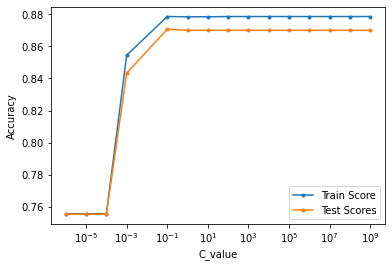

In [84]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, test_scores,label="Test Scores",marker='.')
plt.xscale('log')
plt.xlabel('C_value')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

- As mentioned, the c_value is set to 1.0 by default.
- It appears the 'elbow' C_value is around 0.001, but continues to still train and provide slightly higher accuracy when increased to 1, plateauing there after.
- Will further explore additional hyperparameter optimization by grid searching additional models and parameters below. 

## Grid Searching
The final modeling process seeks to optimize various scalers, dimensionality reduction, and classifiers. This can be achieved by creating and fitting a GridSearchCV model. Below are the different models selected with a brief explanation for choosing each model and their unique qualities for tackling this classification problem.
- Support vector machines (SVMs)
    - maximizes the distance(margin) between the decision boundary and the closest points from the training data.
- K Nearest Neighbors (KNN)
    - Dealing with multi-class data using KNN is simpler. The decision rule for a given point is just the most common class amongst the  𝐾  nearest neighbor.
- Decision Tree 
    - Learns highly non-linear decision boundaries on multi-class data. Unlike KNN, it is not a distance-based classifier constrained to learn using notions of closeness. Instead it works by chaining together simple binary classifiers.


- **NOTE**: The below GridSearchCV model take's about ~10-15 minutes to run.

In [85]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [
    ('normalise', StandardScaler()),
    ('dim_reduction', PCA()),
    ('model', svm.SVC())
]


pipe = Pipeline(estimators)

param_grid = [
            {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [DecisionTreeClassifier()], 
                'model__max_depth': range(1, 10),
            },# number of combinations here: 3 * 3 * 1 * 9 = 81
            {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction__n_components': [3, 5, 10],
                'model': [LogisticRegression()], 
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            },# number of combinations here: 3 * 3 * 1 * 7 = 63
             {
                'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
                'dim_reduction': [None],
                'model': [KNeighborsClassifier()], 
                'model__n_neighbors': range(1, 40, 2),
            },# number of combinations here: 3 * 1 * 1 * 20 = 60
    
] # total: 204 parameter combinations for pipeline

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1) # this will call fit and score 5 * 204 = 1020 total fits

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 204 candidates, totalling 1020 fits


In [86]:
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', RobustScaler()),
                ('dim_reduction', PCA(n_components=10)),
                ('model', LogisticRegression(C=10))])

In [87]:
# final reported performance of the best estimator
print(f"Best GridSearch score: {fittedgrid.score(X_test, y_test)}")
print(f"Standard Scaler Test score: {logreg_ss_test_acc}")

Best GridSearch score: 0.8693661971830986
Standard Scaler Test score: 0.8700704225352113


- It appears that throwing loads of computer power resulted in reinforcing that the LogisticRegression is still the best model. The Standard Scaler version provides slightly better test accuracy with no dimensionality reduction, and a default c-value of 1.
- Final steps will be to evaluate the best model to determine just how informative it really is as well as derive final insights.

### Interpreting Coefficients
The predictor's coefficients help determine their impact on the odds of a driver finishing in the Top 5. This will be visualized by creating a dataframe that charts the exponential of the coefficient by applying the **np.exp()** function, and then sorted by greatest-least with a top 10 filter applied as seen below.
- A noticeable difference in odds are observed when comparing the different scaler models of LogisticRegression to each other, in which ultimately provide confusing results. 
- Another difference noticed was penality of the LR model. By default, penality is 'L2' in sklearn logistic regression model which distorts the value of coefficients (regularization), but if penality='none', the odds ratios slightly increase.

In [88]:
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,4.142332
"(barrichello,)",1.635375
"(Ferrari,)",1.585565
"(hamilton,)",1.532725
"(trulli,)",1.525036
"(fisichella,)",1.521947
avg_lap_time,1.482273
"(alonso,)",1.460825
"(German,)",1.456810
"(Finnish,)",1.449243


- These are the results from the most previous run logreg model, which is believed to be from the grid search. There were several attempts to acquire the best fittedgrid model's coefficient, however it appears there is no such method allowed.
- Interesting take away from these results is a driver who has or shares the most `completed_laps` is over **4** times more likely (the odds increase **4.142332** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.

In [89]:
logreg = LogisticRegression() # c-value default is set to 1.0
logreg.fit(X_train, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,1.050239
"(Ferrari,)",1.008140
"(C.German,)",1.004912
"(Mercedes,)",1.004753
"(C.Austrian,)",1.004220
"(Red Bull,)",1.004220
"(German,)",1.003799
"(hamilton,)",1.003785
"(Finnish,)",1.003708
"(McLaren,)",1.003137


In [90]:
logreg = LogisticRegression(penalty='none') # c-value default is set to 1.0
logreg.fit(X_train, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,1.050243
"(Ferrari,)",1.008140
"(C.German,)",1.004912
"(Mercedes,)",1.004753
"(C.Austrian,)",1.004220
"(Red Bull,)",1.004220
"(German,)",1.003799
"(hamilton,)",1.003786
"(Finnish,)",1.003708
"(McLaren,)",1.003137


- A `Ferrari`, `Mercedes`, `Red Bull` or `McLaren` driver is over **1** times more likely to finish in the Top 5 compared to all other drivers racing for different constructors having all other features the same.
- `German` & `Austrian` teams are over **1** times more likely to finish in the Top 5 compared to all other teams of different nationalities having all other features the same.

In [91]:
logreg = LogisticRegression()
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_ss, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,4.091586
avg_lap_time,1.472513
"(Ferrari,)",1.451369
"(alesi,)",1.267568
"(hamilton,)",1.247958
"(barrichello,)",1.246181
"(vettel,)",1.227249
"(alonso,)",1.224868
"(panis,)",1.211987
"(Mercedes,)",1.208028


- A driver who has or shares the most `completed_laps` is over **4** times more likely (the odds increase **4.091586** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.

In [92]:
logreg = LogisticRegression()
scaler = MinMaxScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_mm = scaler.transform(X_train)
X_test_mm = scaler.transform(X_test)

# fit model on scaled data
logreg.fit(X_train_mm, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,228.964406
avg_lap_time,17.968575
"(Ferrari,)",3.398518
"(alesi,)",3.245891
"(hamilton,)",3.147793
"(alonso,)",2.894645
"(herbert,)",2.807337
"(barrichello,)",2.756093
"(vettel,)",2.751811
"(max_verstappen,)",2.699343


- A driver who has or shares the most `completed_laps` is over **229** times more likely (the odds increase **228.964406** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.
- This intense amount of odds is assumed to be related from the effects of the scaler.

In [93]:
logreg = LogisticRegression()
scaler = RobustScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_rs = scaler.transform(X_train)
X_test_rs = scaler.transform(X_test)

logreg.fit(X_train_rs, y_train)

odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, X.columns, columns=['Odds']).sort_values(by='Odds', ascending=False).head(10)

,Odds
completed_laps,3.926437
"(alesi,)",3.401349
"(Ferrari,)",3.266311
"(herbert,)",2.907656
"(hamilton,)",2.902686
"(alonso,)",2.878228
"(vettel,)",2.769409
"(barrichello,)",2.750101
"(irvine,)",2.591169
"(max_verstappen,)",2.577426


- A driver who has or shares the most `completed_laps` is almost **4** times more likely (the odds increase **3.926437** fold) to finish in the Top 5 compared to all other drivers finishing the race with fewer completed laps and yet having all other features the same.

### Confusion Matrix
A confusion matrix will be created to examine how the data points were classified for the best logistic regression model seen below. This is observed on the Standard Scaled LR model where penalty = 'None', with no dimensionality reduction, and default c-value of 1. 
- Note this model is chosen due to producing the highest test accuracy, along with slightly higher odds in `completed_laps`.

In [119]:
# Fitting a model
logreg = LogisticRegression(penalty='none') # c-value default is set to 1.0
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)
# fit model on scaled data
logreg.fit(X_train_ss, y_train)
# Training and test score
print(f"Train score: {logreg.score(X_train_ss, y_train)}")
print(f"Test score: {logreg.score(X_test_ss, y_test)}")

Train score: 0.8786598249320857
Test score: 0.8700704225352113


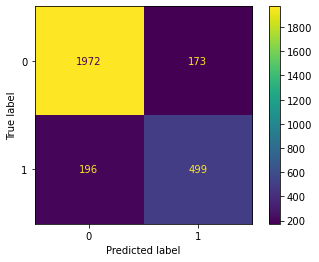

In [111]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# fit model on scaled data
Best_LR_model = LogisticRegression(penalty='none') # c-value default is set to 1.0
scaler = StandardScaler()
# fit the scaler to the X_train data
scaler = scaler.fit(X_train)
# transform both the X_train and X_test data with the fitted scaler
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

Best_LR_model.fit(X_train_ss, y_train)

#visualize the matrix
plot_confusion_matrix(Best_LR_model, X_test_ss, y_test)

- This is a good start but a bit uninterruptible, by making the same confusion matrix by hand there is a bit more information that can provide further insight into the performance of this model.

In [113]:
# Classify the test set
y_pred = Best_LR_model.predict(X_test_ss)

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=['Predicted 0', 'Predicted 1'])

# Add a column that sums up the actuals
confusion_df['Sum of Actuals'] = confusion_df.sum(axis=1)

# Add a row that sums up the predictions
confusion_df = confusion_df.append(pd.Series(confusion_df.sum(axis=0)), ignore_index=True)

# Fix the indices
confusion_df.index=['Actual 0', 'Actual 1', 'Sum of Predictions'] 

# Check
confusion_df

,Predicted 0,Predicted 1,Sum of Actuals
Actual 0,1972,173,2145
Actual 1,196,499,695
Sum of Predictions,2168,672,2840


Accuracy, precision and recall can now be manually calculated. This isn't necessary, but it helps in understanding the performance of this model.

#### Accuracy
- Model accuracy is defined as the number of classifications a model correctly predicts divided by the total number of predictions made. It's a way of assessing the performance of a model, but certainly not the only way.

In [114]:
# Accuracy: (TN + TP) / All
(1972+499) / 2840

0.8700704225352113

#### Precision
- Measure of how focused the model is
- Another interpretation: Given a data point that the model has classified as a member of the positive class, what's the probability that this _in fact_ belongs to the positive class?

In [115]:
# Precision: TP / (TP + FP)
499 / 672

0.7425595238095238

#### Recall
- Measure of how well the model "captures" members of the positive class
- Another interpretation: Given a data point belonging to the positive class, what's the probability that the model will classify it as a member of the positive class?

In [116]:
# Recall: TP / (TP + FN)
499 / 695

0.7179856115107913